# 1. XGBoost(eXtra Gradient Boost) 개요
트리 기반의 알고리즘의 앙상블 학습에서 각광받는 알고리즘 중 하나  
GBM 기반이지만, GBM의 단점인 느린 수행시간과 과적합 규제 등을 해결한 알고리즘

> **주요 장점**
- 뛰어난 예측 성능
- GBM 대비 빠른 수행 시간 : CPU 병렬 처리, GPU 지원
- 다양한 성능 향상 기능 : 규제(Regularization)기능 탑재, Tree Pruning[가지치기])
- 다양현 편의 기능 : 조기 중단(early Stopping), 자체내장 교차검증, 결손값 자체 처리 

> **사이킷런 하이퍼 파라미터**

|파라미터명 <br>(파이썬 래퍼)|파라미터명<br>(사이킷런 래퍼)|설명|
|:---:|:---:|:---|
|**eta**<br>(0.3)|l**earning_rate**<br>(0.1)|- GBM의 학습률과 같은 파라미터<br>- 부스팅 스텝 반복 수행시 업데이트 되는 학습률 값<br> - 범위 0~1|
|**num_boost_rounds**<br>(10)|**n_estimators**<br>(100)|- 사이킷런 앙상블의 n_estimators와 동일<br> - 약한 학습기의 개수(반복 수행횟수)|
|**min_child_weight**<br>(1)|**min_child_weight**<br>(1)|- 결정트리의 min_child_leaf와 유사<br> - 과적합 조절용<br>- 범위 0~∞|
|**max_depth**(<br>6)|**max_depth**<br>(3)|- 결정트리의 max_depth와 동일<br>- 0 지정하면 깊이 제한 없음<br>- 너무 크면 과적합(통상 3 ~ 10정도 적용)<br>- 범위 0~∞|
|**sub_sample**<br>(1)|**subsample**<br>(1)|- GBM의 sumsample과 동일<br>- 트리가 커져 과적합 되는 것을 제어 위해 데이터 샘플링 비율 지정<br>- 범위 0~1|
|**lambda**<br>(1)|**reg_lambda**<br>(1)|- L2 규제(Regularization) 적용 값<br>- 클수록 과적합 감소 효과|
|**alpha**<br>(0)|**reg_alpha**<br>(0)|-  L1 규제(Regularization) 적용<br>- 클수록 과적합 감소 효과|
|**colsample_bytree**<br>(1)|**colsample_bytree**<br>(1)|- GBM의 max_features와 유사<br>- 트리 생성에 필요한 피처의 샘플링에 사용<br>- 피처 많을 때 과적합 조절에 사용<br>- 범위 0~1|
|**scale_pos_weight**<br>(1)|**scale_pos_weight**<br>(1)|- 불균형 데이터셋의 균형 유지|
|**gamma**<br>(0)|**gamma**<br>(0)|-리프노드 추가분할 결정할 최소손실 감소값<br>- 해당값보다 큰 손실이 감소된 경우 분리<br>- 값이 클수록 과적함 감소 효과|

> **조기 중단 기능(Early Stopping)**
- 특정 반복 횟수 만큼 더 이상 비용함수가 감소되지 않으면 지정 반복횟수 다 완료하지 않고 수행 종료 가능
- 학습 시간 단축 시킬 수 있고, 특히 최적화 튜닝 단계에서 적절하게 사용 가능
- 너무 반복횟수 단축할 경우 예측 성능 최적화가 안된 상태에서 학습 종료 될 수 있으므로 유의 필요
 
> **조기 중단 설정을 위한 주요 파라미터**
- early_stopping_rouds : 더 이상 비용 평가 지표가 감소하지 않는 최대 반복횟수
- eval_metirc : 반복 수행시 사용하는 비용 평가지표
- eval_Set : 평가 수행하는 별도 검증 데이터 셋, 일반적으로 검증 데이터 셋에서 반복적으로 비용 감소 성능 평가

In [1]:
# XGBoost 설치 : 프롬프트(관리자권한) -> conda install -c anaconda py-xgboost
import xgboost

# XGBoost 버전 확인
print(xgboost.__version__)

1.5.0


# 2. 파이썬 wrapper용 XGBoost 적용
위스콘신 Breast Cancer 데이터 셋

In [2]:
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

# 유방암 데이터셋 정보 확인
print(dataset.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [3]:
# feature, target 명 확인
print(dataset.feature_names)
print('\n', dataset.target_names)
print('\n', dataset.target)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

 ['malignant' 'benign']

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 

In [4]:
# 데이터는 피처, 타겟은 라벨
X_features= dataset.data
y_label = dataset.target

# 데이터 확인 위해 데이터프레임으로 생성
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)

cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [5]:
# 1이면 malignant(악성), 0이면 benign(양성)
print(cancer_df['target'].value_counts())

1    357
0    212
Name: target, dtype: int64


In [6]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


**학습과 예측 데이터 세트를 DMatrix로 변환**

In [7]:
# DMatrix : Numpy 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 셋
# Panda의 Dataframe으로 데이터 인터페이스를 하기 위해서 DafaFrame.values를 이용해 Numpy로 일차변환 뒤 DMatirx 변환 적용
# Numpy 형태의 학습/테스트 데이터 셋을 DMatrix로 변환
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

**하이퍼 파라미터 설정**

In [8]:
# eta는 학습률(learning_rate)로 0.1
# 데이터 셋이 이진분류 이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수 평가성능지표 logloss
# 조기중단 위한 최소 반복횟수 100
# 부스팅 반복횟수 400
params = {'max_depth':3, 
          'eta': 0.1, # learning_rate
          'objective':'binary:logistic', # 생략가능
          'eval_metric':'logloss', 
          'early_stoppings':100
         }
num_rounds = 400

**주어진 하이퍼 파라미터와 early stopping 파라미터를 train()함수의 파라미터로 전달하고 학습**  
파이썬래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train()함수에 파라미터로 전달   
(사이킷런 래퍼는 Estimator 생성자를 하이퍼 파라미터로 전달)   
train()함수 호출하면 xgboost가 반복시마다 eval에 표시된 데이터 세트에 대해 평가지표 출력후 학습이 완료된 모델 객체 반환

In [9]:
# train 데이터 셋은'train', evaluation(test) 데이터 셋은 ‘eval'로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , evals=wlist )

[18:01:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0

[162]	train-logloss:0.00724	eval-logloss:0.08776
[163]	train-logloss:0.00722	eval-logloss:0.08778
[164]	train-logloss:0.00720	eval-logloss:0.08778
[165]	train-logloss:0.00718	eval-logloss:0.08752
[166]	train-logloss:0.00716	eval-logloss:0.08754
[167]	train-logloss:0.00714	eval-logloss:0.08764
[168]	train-logloss:0.00712	eval-logloss:0.08739
[169]	train-logloss:0.00710	eval-logloss:0.08738
[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:

[330]	train-logloss:0.00533	eval-logloss:0.08587
[331]	train-logloss:0.00532	eval-logloss:0.08589
[332]	train-logloss:0.00532	eval-logloss:0.08592
[333]	train-logloss:0.00531	eval-logloss:0.08584
[334]	train-logloss:0.00531	eval-logloss:0.08574
[335]	train-logloss:0.00530	eval-logloss:0.08582
[336]	train-logloss:0.00529	eval-logloss:0.08589
[337]	train-logloss:0.00529	eval-logloss:0.08594
[338]	train-logloss:0.00528	eval-logloss:0.08583
[339]	train-logloss:0.00528	eval-logloss:0.08591
[340]	train-logloss:0.00527	eval-logloss:0.08583
[341]	train-logloss:0.00526	eval-logloss:0.08573
[342]	train-logloss:0.00526	eval-logloss:0.08568
[343]	train-logloss:0.00525	eval-logloss:0.08572
[344]	train-logloss:0.00525	eval-logloss:0.08580
[345]	train-logloss:0.00524	eval-logloss:0.08582
[346]	train-logloss:0.00524	eval-logloss:0.08571
[347]	train-logloss:0.00523	eval-logloss:0.08579
[348]	train-logloss:0.00523	eval-logloss:0.08583
[349]	train-logloss:0.00522	eval-logloss:0.08573
[350]	train-logloss:

train()을 통해 학습 수행하면서 반복시 train-logloss와 eval-logloss가 지속적으로 감소   
xgboost를 이용해 학습이 완료됐으면 predict() 메서드를 이용해 예측 수행  
파이썬 래퍼는 예측 결과를 추정할 수 있는 호가률 값을 반환(사이킷런래퍼는 클래스값 반환)

**predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환**

In [10]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


**get_clf_eval( )을 통해 예측 평가**

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 혼동행렬, 정확도, 정밀도, 재현율, F1 SCORE, AUC 불러오기
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [12]:
# 예측평가 확인
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


**Feature Importance시각화**
- 기본 평가 지표로 F1 스코어 기반 각 Feature의 중요도 나타낸다
- 사이킷런 래퍼는 estimator객체의 feature_importances 속성을 이용해 시각화 코드 직접 작성 필요
- 파이썬 래퍼는 plot_importance()을 이용해 바로 피처 중요 코드 시각화 가능
- xgboost 넘파이 기반의 피처 데이터로 학습시 피처명 알수 없으므로 피처별로 f자 뒤에 순서를 붙여 X축에 피처들로 나열(f0는 첫번째 피처, f1는 두번째 피처를 의미)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

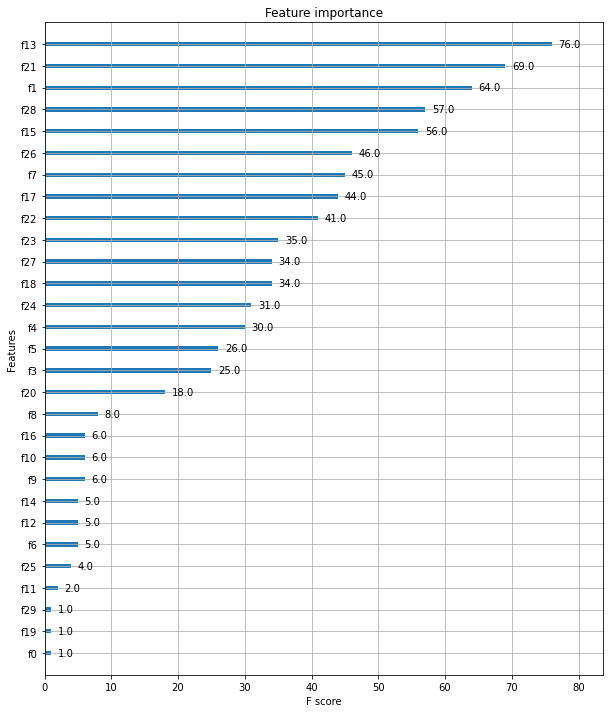

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

# 3. 사이킷런 Wrapper XGBoost 개요 및 적용 
위스콘신 Breast Cancer 데이터 셋  
> 특징
- 사이킷런의 기본 Estimator를 이용해 만들어 fit()과 predict()만으로 학습/예측 가능
- GridSearchCV, Pipeline등 사이킷런 유틸리티 그대로 사용가능
- 분류(XGBClassifier), 회귀(XGBRegressor)

> 파이썬 래퍼와 비교시 달라진 파라미터
- eta -> learning_rate
- sub_sample -> subsample
- lambda -> reg_lambda
- alpha -> reg_alpha
- num_boost_round -> n_estimators

In [14]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 400

# 평가를 위해 데이터 셋을 테스트 데이터 셋으로 사용했지만
# 테스트 데이터 세트는 학습에 완전히 사용되지 않아야 하므로 바람직하지 않음
# 평가시 테스트 데이터 셋을 사용하면 학습시에 미리 참고 되므로 과적합 가능성 증가

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train , y_train,  early_stopping_rounds=400,eval_set=evals, eval_metric="logloss",  verbose=True)

w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [15]:
# 예측결과 확인
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


앞선 파이썬 래퍼 XGBoost와 동일 결과가 나오는것을 확인 가능

**early stopping을 100으로 설정하고 재 학습/예측/평가**  

In [16]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

# early_stopping_rounds = 100 으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

위 결과에서 211번 반복시 logloss가 0.08559 이었는데, 이후 100번 반복되는 311번까지 성능평가 지수가 향상되지 않았기에 더 이상 반복하지 않고 멈춤

**early stopping을 10으로 설정하고 재 학습/예측/평가**  
조기 중단값을 너무 급격하게 줄이면 성능 향상될 여지가 있음에도 학습을 멈춰 예측 성능 저하 가능성 있음

In [17]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

61번까지만 수행 후 종료 시의 학습 모델 예측 정확도는 0.9561  
ealry_stopping_rounds = 100일 때의 학습 모델 예측 정확도는 0.9649보다 낮게 나옴

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

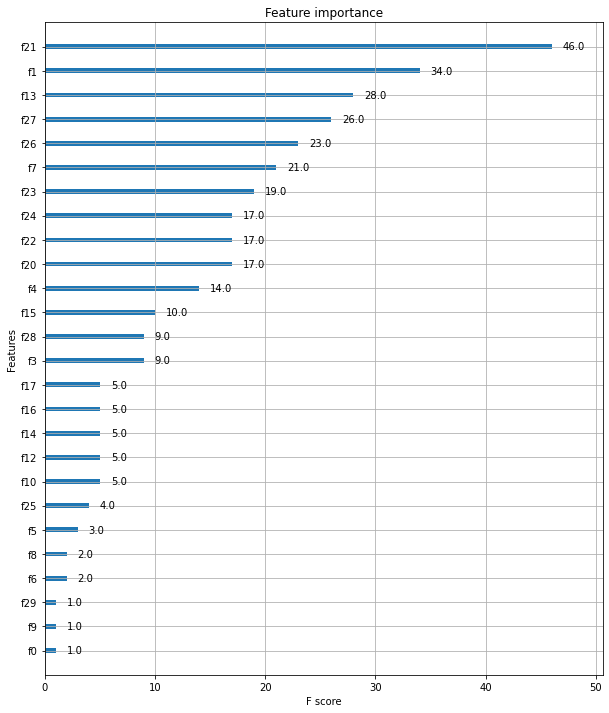

In [18]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)